# Gas powerplant investigation
- In this file I will make investigations that will be useful for the final program 
- Now this investigation has turned itself to being almost a final program for the modelling. 

- The new goal is to follow a structure of work as in the algo project. 
    - I will make an investigation of how to do the actual implementation of the simulation. 
    - I will make python "package" that can be called from these notebooks, or from the terminal for example. 


# What needs to be done in general 
- First, which is almost ready is the simulation of the problem. State setup, transition probabilities working, rewards being given, etc. 
    - The goal of the simulation is to be able to give a simple strategy and test how it will work out in terms of monte carlo. 
    - In the end, this simulation will be used with the "optimal" strategy to determine the different valuations that will be given to the project, based on parameters. 
    
- Second half of the work is to identify the optimal ADP algorithm and to find the best strategy on this framework. This will be more complicated and a prior research needs to be done before. 

# Preparation and testing of different distributions

## Modeling lognormal variables 
- What do the price graphs look like for different distribtuion variables. 
- I want to model price of gas, CO2 and power with this. 

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
def plot_lognorm_price(delta, x, n):

    price = []
    for k in range(n):
        x = np.exp(np.log(x)+norm.rvs(scale = delta))
        price.append(x)
    plt.plot(price)
    plt.xlabel('days')
    plt.ylabel("EUR")

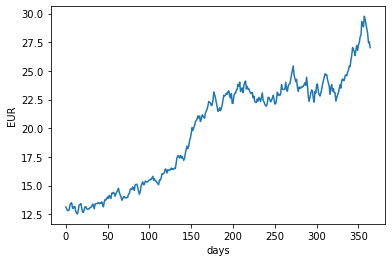

In [3]:
plot_lognorm_price(0.015, 13, 365)

## Modelling a three-output random variable
- I want to use this model for the modelling of government support for the renewables. 
- Higher support is reflected in the higher volatility of power prices. 
- A random variable is either an increase in the support, decrease, or in the majority of cases "no change". 

In [4]:
plus_prob = 0.08
minus_prob = 0.03
zero_prob = 1-plus_prob - minus_prob
current_state = 1

In [5]:
def get_gov_evolution(plus_prob, minus_prob, n, initial_state): 
    zero_prob = 1-plus_prob - minus_prob
    current_state = initial_state
    
    states = []
    
    for i in range(n): 
        
        current_move = np.random.choice(np.arange(1, 4), p=[minus_prob, zero_prob, plus_prob])-2
        if(current_state+current_move in range(1,6)):
            current_state = current_state+current_move 
            states.append(current_state)
    return(states)

In [6]:
def plot_gov_evolution(plus_prob, minus_prob, n, initial_state):
    
    states = get_gov_evolution(plus_prob, minus_prob, n, initial_state)
    
    plt.plot(states)
    plt.xlabel('months')
    plt.ylabel("Intensity")

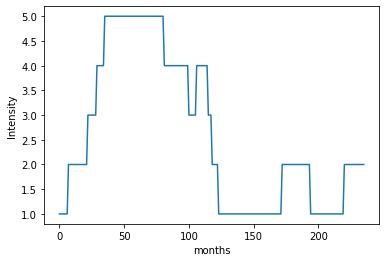

In [7]:
plot_gov_evolution(0.025,0.01,240,1)

In [8]:
evolutions = []
for i in range(1000): 
    evolutions.append(get_gov_evolution(0.025, 0.01, 240, 1))

In [9]:
avg_run = list(map(lambda x: sum(x)/len(x), zip(*evolutions)))

Text(0, 0.5, 'Intensity')

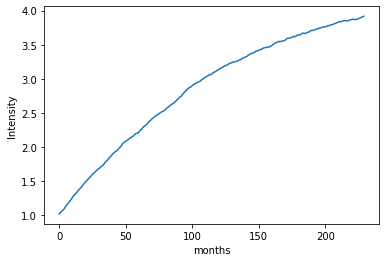

In [10]:
plt.plot(avg_run)
plt.xlabel('months')
plt.ylabel("Intensity")

# Mortgage computation 
- What will be the monthly payment, when I borrow for the powerplant 

In [11]:
from mortgage import Loan

loan = Loan(principal=65000000, interest=.03, term=20)
loan.summarize

Original Balance:         $ 65,000,000
Interest Rate:                    0.03 %
APY:                              3.04 %
APR:                              3.00 %
Term:                               20 years
Monthly Payment:          $  360488.44

Total principal payments: $65,000,000.00
Total interest payments:  $21,517,225.27
Total payments:           $86,517,225.27
Interest to principal:            33.1 %
Years to pay:                     20.0


In [12]:
loan.monthly_payment

Decimal('360488.44')

# One step of the evolution 
- This will be used in monte carlo simulation after we obtain the optimal decision strategy from the ADP optimization. 

- Price evolution of power, gas and CO2. 
- Evolution of the government policy
- Evolution of project state based on actions 
- Evolution of repayment of the loans based on the state. 


## Price evolution of power
- Already somehow done in the beginning of this notebook. 

In [13]:
def get_next_price(current_price, volatility): 
    return(np.random.lognormal(np.log(current_price), volatility))

In [14]:
prices = []
current_price = 40
prices.append(current_price)

government_policy = 3

for i in range(300): 
    volatility = 0.05*((1+(government_policy-1)*0.2))
    current_price = get_next_price(current_price,0.05)
    prices.append(current_price)

Text(0, 0.5, 'EUR')

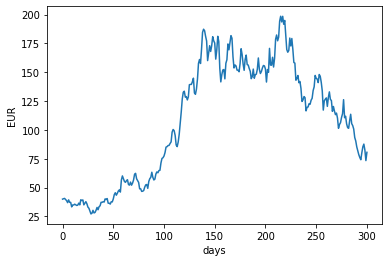

In [15]:
plt.plot(prices)
plt.xlabel('days')
plt.ylabel("EUR")

It looks somehow reasonable. 

## Price evolution for gas 
- Will be very similar to that of power. 

In [16]:
prices = []
current_price = 24
prices.append(current_price)

for i in range(300): 
    current_price = get_next_price(current_price,0.04)
    prices.append(current_price)

Text(0, 0.5, 'EUR')

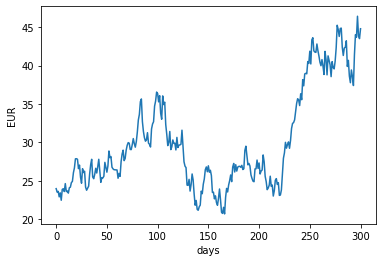

In [17]:
plt.plot(prices)
plt.xlabel('days')
plt.ylabel("EUR")

## Price evolution of CO2 
- now with a lower volatility

In [18]:
prices = []
current_price = 24
prices.append(current_price)

for i in range(300): 
    current_price = get_next_price(current_price,0.02)
    prices.append(current_price)

Text(0, 0.5, 'EUR')

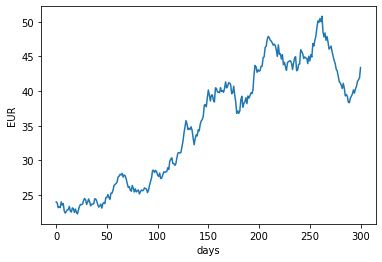

In [19]:
plt.plot(prices)
plt.xlabel('days')
plt.ylabel("EUR")

## Government policy evolution 
- Again was already done before, so it is only a reinterpretation. 

In [20]:
def get_next_gov_policy(gov_policy, negative_prob, positive_prob): 
    zero_prob = 1 - positive_prob - negative_prob
    
    movement = np.random.choice(np.arange(1, 4), p=[negative_prob, zero_prob, positive_prob, ])-2

    if(gov_policy+movement in range(1,6)):
        gov_policy = gov_policy + movement
    return(gov_policy)

In [21]:
gov_policy = 1

In [22]:
gov_policy = get_next_gov_policy(gov_policy, 0.03, 0.08)
gov_policy

1

In [23]:
gov_policies = []
gov_policy = 1
gov_policies.append(gov_policy)

for i in range(300): 
    gov_policy = get_next_gov_policy(gov_policy,0.007, 0.02)
    gov_policies.append(gov_policy)

Text(0, 0.5, 'intensity')

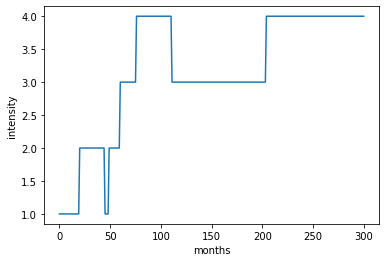

In [24]:
plt.plot(gov_policies)
plt.xlabel('months')
plt.ylabel("intensity")

## Project state based on action 
- State of production - 0: not running 1: running 2: not running mothballed
- Capacity of production - 0: 0MW, 1: 200MW, 2: 400MW  
    
- Two dimensions are not needed, there are only these actions possible: 
    - 0: Do not run and do not build the next stage - available in all states. 
    - 1: Run what is built and do not build new stage - available when there is something to run even mothballed. 
    - 2: Run what is built and build a new stage -  only available at 200MW capacity. 
    - 3: Do not run and build the next stage - only available at 0 and 200 MW capacity 
    - 4: mothball the plant 
    - 5: sell everything for salvage value
    
   

## Possible states encoding 
- \[0,0\] - power plant was not built yet. 

\[1,0\] and \[2,0\] - do not make sense. We encode one more state with this tuple [1,0] running at 0 MW will mean that we have sold the plant. 

\[0,1\] - 200MW installed and not running 

\[1,1\] = 200MW build and running 

\[1,2\] - 400MW built and running 

\[2,1\] - 200MW mothballed 

\[2,2\] - 400 MW mothballed

In [25]:
[[i,j] for i in range(0,3) for j in range (0,3) if [i,j]!= [2,0]]

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 1], [2, 2]]

In [26]:
possible_states = [[i,j] for i in range(0,3) for j in range (0,3) if [i,j]!= [2,0]]
possible_actions = range(0,6)

In [27]:
[0,0] not in possible_states

False

In [28]:
def is_the_action_possible(state, action): 
    
    if (state not in possible_states): 
        print("The state: " +str(state)+ " is not allowed")
        return False
    
    if (action not in possible_actions): 
        print("This action is not allowed")
        return(False)
    
    # When the plant is sold, the only action allowed is to do nothing. 
    if (state == [1,0]): 
        if action != 0: 
            print("The plant was sold, no action that does something is allowed")
            return(False) 
    

    if action == 1: 
        if(state[1] == 0): 
            print("No capacity can be run. Installed capacity is 0")
            return(False)
        
    #Run 200 MW and build new stage
    if action == 2: 
        if(state[1] != 1): 
            print("Cannot run and build a new stage when the stage is not 200MW")
            return(False)
    
    if action == 3: 
        if(state[1] == 2): 
            print("Cannot build the new stage when the capacity is already 400MW. ")
            return(False)
        
    if action == 4:   
        if (state[1]==0): 
            print("There is nothing to mothball.")
            return(False)
    
    if action == 5: 
        if(state[1]==0): 
            print("There is nothing to sell")
            return(False)
        
    return(True)

In [29]:
def get_next_project_state(state, action): 
 
    if(not is_the_action_possible(state,action)): 
        print("The action " + str(action) + " is not possible in the state " + str(state))
        return(None)
    
    # If the plant was sold, I cannot do anything
    if (state == [1,0]): 
        return(state) 
    
    # Not runnig and not changing capacity. 
    if action == 0: 
        return([0, state[1]])

    # run what is build and not change capacity 
    if action == 1: 
        return([1,state[1]])

    #Run 200 MW and build new stage
    if action == 2: 
        return([1,2])

    #Do not run and build new stage: 
    if action == 3: 
        return([0,state[1]+1])
        
    # Mothball the plant 
    if action == 4: 
        return([2,state[1]])
    
    #Sell the plant 
    if action == 5:
        return([1,0])

In [30]:
not is_the_action_possible([0,0], 1)

No capacity can be run. Installed capacity is 0


True

In [31]:
get_next_project_state([0,0], 3)

[0, 1]

In [32]:
for state in possible_states: 
    for action in possible_actions: 
        print(str(state) + " " + str(action))
        print(get_next_project_state(state, action))

[0, 0] 0
[0, 0]
[0, 0] 1
No capacity can be run. Installed capacity is 0
The action 1 is not possible in the state [0, 0]
None
[0, 0] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible in the state [0, 0]
None
[0, 0] 3
[0, 1]
[0, 0] 4
There is nothing to mothball.
The action 4 is not possible in the state [0, 0]
None
[0, 0] 5
There is nothing to sell
The action 5 is not possible in the state [0, 0]
None
[0, 1] 0
[0, 1]
[0, 1] 1
[1, 1]
[0, 1] 2
[1, 2]
[0, 1] 3
[0, 2]
[0, 1] 4
[2, 1]
[0, 1] 5
[1, 0]
[0, 2] 0
[0, 2]
[0, 2] 1
[1, 2]
[0, 2] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible in the state [0, 2]
None
[0, 2] 3
Cannot build the new stage when the capacity is already 400MW. 
The action 3 is not possible in the state [0, 2]
None
[0, 2] 4
[2, 2]
[0, 2] 5
[1, 0]
[1, 0] 0
[1, 0]
[1, 0] 1
The plant was sold, no action that does something is allowed
The action 1 is not possible in the state [1, 0]
None
[

## Rewards from project state change
- There is a price for building new stage - actions 2 and 3 costing 65M EUR. 
- There is a reward for selling for salvage value, This is a function of time. 

- There is a cost to mothball the plant. 
- There is the same cost to unmothball the plant

In [33]:
powerplant_cost = 65000000
mothballing_cost = 500000
salvage_value_month = 50000 

In [34]:
def get_project_reward(state, action, time_left): 
    profit = 0
    
    if(not is_the_action_possible(state,action)): 
        return(profit)
    
    # Building new capacity 
    if action == 2 or action ==3: 
        profit = -powerplant_cost
    
    #Unmothballing
    if state[0]==2: 
        if(action in range(0,4)): 
            return(profit-mothballing_cost)
    else: #Mothballing
         if(action == 4): 
            return(profit - mothballing_cost) 

    # Selling for salvage value 
    if(action == 5): 
        return(state[1]*salvage_value_month*time_left)
    
    return(profit)

In [35]:
for state in possible_states: 
    for action in possible_actions: 
        print(str(state) + " " + str(action))
        print(get_next_project_state(state, action))
        print("Profit:" + str(get_project_reward(state,action, 5)))

[0, 0] 0
[0, 0]
Profit:0
[0, 0] 1
No capacity can be run. Installed capacity is 0
The action 1 is not possible in the state [0, 0]
None
No capacity can be run. Installed capacity is 0
Profit:0
[0, 0] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible in the state [0, 0]
None
Cannot run and build a new stage when the stage is not 200MW
Profit:0
[0, 0] 3
[0, 1]
Profit:-65000000
[0, 0] 4
There is nothing to mothball.
The action 4 is not possible in the state [0, 0]
None
There is nothing to mothball.
Profit:0
[0, 0] 5
There is nothing to sell
The action 5 is not possible in the state [0, 0]
None
There is nothing to sell
Profit:0
[0, 1] 0
[0, 1]
Profit:0
[0, 1] 1
[1, 1]
Profit:0
[0, 1] 2
[1, 2]
Profit:-65000000
[0, 1] 3
[0, 2]
Profit:-65000000
[0, 1] 4
[2, 1]
Profit:-500000
[0, 1] 5
[1, 0]
Profit:250000
[0, 2] 0
[0, 2]
Profit:0
[0, 2] 1
[1, 2]
Profit:0
[0, 2] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible 

Now it all fits. 

# Change in the payments state 
- If the new state provi

# Reward computation 
- First, write the FCF function, decide if it is enough for the loan payment and if yes, then subtract that and move the state of payments. 

In [36]:
number_of_payments = 240
payment_size = 360000

In [37]:
def get_next_payment_state(payment_state,FCF, action):
    ps = payment_state.copy()
    # building fist stage 
    if action == 2: 
        ps[0]=number_of_payments
        return(ps)
   
    # building the second stage
    if action == 3: 
        ps[1]=number_of_payments
        return(ps)
    
    #Repaying the payment 
    
    if FCF>payment_size: 
        if ps[0]>0: 
            ps[0] = ps[0]-1
            if FCF<payment_size*2: 
                return(ps)
            if ps[1]>0: 
                ps[1] = ps[1]-1
                return(ps)
        if ps[1]>0: 
            ps[1] = ps[1]-1
            
    return(ps)

In [38]:
get_next_payment_state([120,5],10000, 0)

[120, 5]

In [39]:
get_next_payment_state([120,5],500000, 0)

[119, 5]

In [40]:
get_next_payment_state([120,5],750000, 0)

[119, 4]

In [41]:
get_next_payment_state([0,0],0, 2)

[240, 0]

In [42]:
get_next_payment_state([5,0],0, 3)

[5, 240]

# FCF computation
- Now I will make the computation of FCF from the state and action

In [43]:
possible_project_states = [[i,j] for i in range(0,3) for j in range (0,3) if [i,j]!= [2,0]]


In [44]:
def state_not_valid(state):

    #Wrong state length 
    if len(state)!=8:
        return(True)

    # non-positive prices 
    if sum(np.sign(state[:3]))<3: 
        return(True)

    #Gov_policy in range
    if state[3] not in range (1,6): 
        return(True)

    #Loans in order: 
    if state[6] not in range(241) or state[7] not in range(241): 
        return(True)

    if state[4:6] not in possible_project_states: 
        return(True)

    return(False)   

In [45]:
a = {"power_price": 24, "gas_price": 23}

In [46]:
state_not_valid([24,9,40,1,1,1,240,0])

False

In [47]:
state_not_valid([-2,9,40,1,1,1,240,0])

True

In [48]:
state_not_valid([9,9,0,1,1,1,240,0])

True

In [49]:
state_not_valid([9,9,24,0,1,1,240,0])

True

In [50]:
state_not_valid([9,9,24,4,2,0,240,0])

True

In [51]:
state_not_valid([9,9,24,4,2,2,-3,0])

True

In [52]:
state_not_valid([9,9,24,4,2,2,1,2])

False

In [53]:
maintanance_cost = 3

In [54]:
moth_maintanance_cost = 1

In [55]:
hours = 720 

In [56]:
MW_count = 200

In [57]:
def repayed(FCF, payment_state, action): 
    diff = [i-j for i,j in zip(payment_state,get_next_payment_state(payment_state, FCF, action))]
    valid_diff =[i for i in diff if i in range(0,2)]
    return(sum(valid_diff)*payment_size)

In [58]:
 valid_diff =[i for i in [1,1] if i in range(0,1)]

In [59]:
payment_state = [120,5]

In [60]:
get_next_payment_state(payment_state, 750000, 0)

[119, 4]

In [61]:
repayed(7500000, [0,0], 2)

0

In [62]:
0 in range(0,1)

True

In [63]:
payment_state = get_next_payment_state(payment_state, 750000, 0)
payment_state

[119, 4]

In [64]:
def get_FCF(state, action, time_left): 
    if(state_not_valid(state)): 
        print("The state is not valid")
        return None
    
    project_state = state[4:6]
    
    capacity = MW_count*project_state[1]
    
    reward = 0 
    
    #Plant is not running
    if project_state[0] == 0:
        #Capacity is non-zero
        if project_state[1] !=0: 
            # And the plant was not built this time epoch
            if action ==3: 
                reward = -maintanance_cost*(capacity-200)*hours
            else: 
                reward = -maintanance_cost*capacity*hours
    
    #Plant is mothballed
    if project_state[0] == 2: 
        if project_state[1] !=0: 
            reward = -moth_maintanance_cost*capacity*hours
    
    if project_state[0] ==1: 
        gas_price = state[0]
        co2_price = state[1]
        power_price = state[2]

        #Reward from selling power
        #print((power_price - gas_price - co2_price-maintanance_cost)*capacity*hours)
        reward += (power_price - gas_price - co2_price-maintanance_cost)*capacity*hours
    #print(get_project_reward(project_state, action, time_left))
    reward += get_project_reward(project_state, action, time_left)
    
    #print(repayed(reward, state[6:8], action))
    loan_payment = repayed(reward, state[6:8], action)
    
    return (reward - loan_payment)
    

In [65]:
get_FCF([24,9,40,1,1,1,239,0], 1, 40)

216000

Now I am able to model the evolution of the subset of the states plus I can compute the FCF of a given state. I am very close to an actual MC simulation based given some (for now heuristic) policy. 

# Setting up the monteCarlo loop 
- I will test the MC loop with a heuristic strategy, which would be to build the 200MW plant in the first time epoch and then run it everytime there is a profit. 
    - This strategy is reasonable and it could be actually really good. 
    


## Variables 

In [66]:
gov_policy = 1 
gov_prob_up = 0.07
gov_prob_down = 0.03

power_price = 40 
power_volatility = 0.04*((1+(gov_policy-1)*0.1))

gas_price = 24 
gas_volatility = 0.03

co_price = 9 
co_volatility = 0.02

fixed_costs = 4

fixed_costs_mothballed = 2

time_epochs =12*25
#[gas,co2,power,gov,running or not, installed MWs, loan for first state, loan for second state]
initial_state = [24,9,40,1,0,0,0,0]

In [67]:
power_volatility

0.04

In [68]:
def get_action_from_strategy(strategy_function, state, epoch): 
    return(strategy_function(state, epoch))

In [69]:
def heuristic_strategy_1(state, epoch): 
    if epoch == 0: 
        return(3) # In the first time epoch we build the powerplant. 
    
    if state[2]-(state[0]+state[1])>0: # We might not turn to profit, but the 
        return(1) # Run the powerplant
    else: 
        return(0) # If the run is not profitable in this stage, do not run the plant. 

In [70]:
def heuristic_strategy_0(state, epoch): 
    if epoch == 0: 
        return(3) # In the first time epoch we build the powerplant. 
    else: #Else we just run it
        return(1)

In [71]:
def get_new_state(state_action): 
    power_volatility = 0.04*((1+(state[3]-1)*0.1))

    gas_price = get_next_price(state[0], gas_volatility)
    co_price = get_next_price(state[1], co_volatility)
    power_price = get_next_price(state[2], power_volatility)
    
    gov_policy = get_next_gov_policy(state[3], gov_prob_down, gov_prob_up)

    project_state = get_next_project_state(state[4:6], action)
    
    


In [72]:
def run_simulation(strategy): 
    state = initial_state
    profit = 0
    global power_volatility
    for epoch in range(time_epochs):
        
        action = get_action_from_strategy(strategy, state, epoch)
                
        gas_price = get_next_price(state[0], gas_volatility)
        co_price = get_next_price(state[1], co_volatility)
        power_price = get_next_price(state[2], power_volatility)
        
        gov_policy = get_next_gov_policy(state[3], gov_prob_down, gov_prob_up)
        
        project_state = get_next_project_state(state[4:6], action)
        
        # The FCF depends on new prices of commodities and the new state of the project. 
        updated_epoch_state = [gas_price, co_price, power_price, gov_policy,
                               project_state[0], project_state[1], state[6], state[7]]

        FCF = get_FCF(updated_epoch_state, action, time_epochs-epoch)     
                                                     
        payment_state = get_next_payment_state(state[6:8], FCF, 0)                                             
                                                     
                                                     
        power_volatility = 0.04*((1+(gov_policy-1)*0.1))
    

#        print("Time_epoch: "+str(epoch))
#         print("Gas_price: "+ str(gas_price))
#         print("CO2_price: "+ str(co_price))
#         print("Power_price: "+ str(power_price))
#         print("Profit per MW: " +str(power_price-gas_price-co_price))
#         print()   
#         print("Action: "+str(action))
#         print("Gov_policy: " + str(gov_policy))
#         print("Project_state: " + str(project_state))
#         print("Payment_state: " + str(payment_state))

#        print("FCF: " + str(FCF))
#         print()
#         print()
        
        state =[gas_price, co_price, power_price, gov_policy, 
                project_state[0], project_state[1], payment_state[0], payment_state[1]]
        
        profit += FCF
    return(profit)

In [73]:
run_simulation(heuristic_strategy_1)

-165086982.80190942

In [74]:
from progressbar import progressbar

In [75]:
results_1 = {}
results_0 = {}

for i in progressbar(range(500)): 
    results_1[i] = run_simulation(heuristic_strategy_1)
    results_0[i] = run_simulation(heuristic_strategy_0)


100% (500 of 500) |######################| Elapsed Time: 0:00:26 Time:  0:00:26


In [76]:
results_1_list = [result for result in results_1.values()]
results_0_list = [result for result in results_0.values()]


In [77]:
results_1_cut = [result for result in results_1.values() if result<1e10]
results_0_cut = [result for result in results_0.values() if result<1e10]


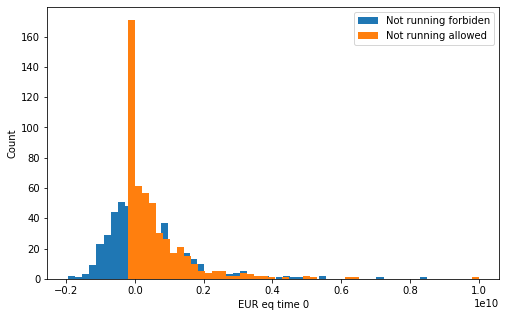

In [78]:
plt.figure(figsize=(8.1,5))
plt.hist(results_0_cut, label = "Not running forbiden", bins = 50)
plt.hist(results_1_cut, label ="Not running allowed", bins = 50)
plt.xlabel("EUR eq time 0")
plt.ylabel("Count")
plt.legend()
plt.savefig('Runnability.png')

In [79]:

plt.savefig('Runnability.png')

<Figure size 432x288 with 0 Axes>

In [80]:
np.mean(results_1_list)

601759015.5274092

In [81]:
np.mean(results_0_list)

360245180.23564607

In [82]:
np.max(list(results_0.values()))/1000000

8488.71321051762

In [83]:
np.min(list(results_1.values()))/1000000

-194.5046573519663

In [84]:
np.mean(list(results_1.values()))

601759015.5274092

In [85]:
np.mean(list(results_0.values()))

360245180.23564607

## PCE function
- Take a vector, simulate responsible manager and return PCE equivalent.

In [86]:
def pce(fcfs, r_r, r_b): 
    balance = 0
    for fcf in fcfs: 
        balance +=fcf
        if balance<0: 
            balance = balance*r_b
        else: 
            balance = balance*r_r
            
    if balance<0: 
        return balance/(r_b)**(len(fcfs))
    else: 
        print(balance)
        return balance/(r_r)**(len(fcfs))

In [87]:
pce([300, -500, 100, -200, 100, 200, 300], 1.02, 1.06)

257.84450862451195


224.46916148277194

Which fits with the computation I made manually 

# Utility function
- We just want to implement an utility function, similar to what we have seen in BacChi literature. 
- And of course with a resonable scale, hundreds of thousands money units. 

In [88]:
import seaborn as sns

In [89]:
sns.set()

In [90]:
def uf_1(x): 
    
    x=x/5000
        
    if x <= 0: 
        return -((-x)**(1/1.7))
    if x<100: 
        return np.log(2*x)
    else: 
        return x**(1/2)-4.7

In [91]:
uf_1(-864000)

-20.711053899961925

In [92]:
uf_1(2700000)

18.5379000772445

In [93]:
r = np.linspace(-400,400,801)
v_uf_1 = np.vectorize(uf_1)
r_u = v_uf_1(r)

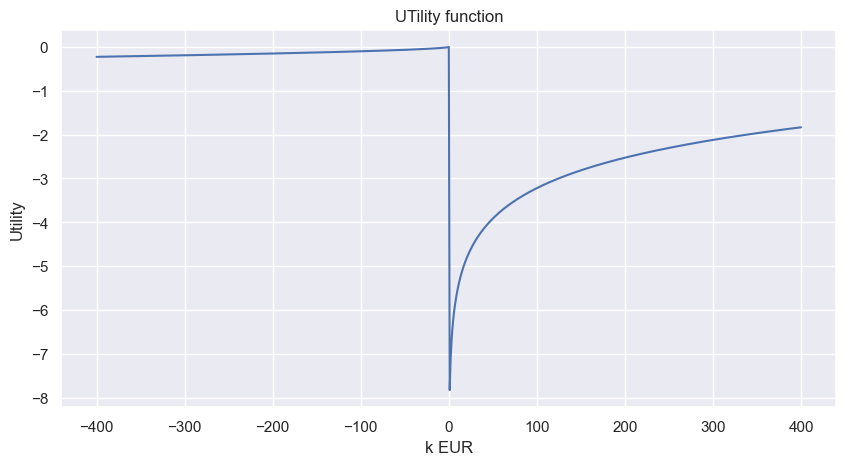

In [94]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(r,r_u)

plt.xlabel("k EUR")
plt.ylabel("Utility")
plt.title("UTility function")

plt.show()

## Does it make sense? 
#### 1. Coin Tosses
- How would a person with this utility function evaluate a 50% toss for 50k, 100k and 250k? 

In [95]:
(uf_1(50)+uf_1(-50))/2 - uf_1(-5)

-1.9721250121495328

In [96]:
(uf_1(100)+uf_1(-100))/2 - uf_1(-15)

-1.6267016854873264

In [97]:
(uf_1(250)+uf_1(-250))/2 - uf_1(-30)

-1.1878055232274511

In [98]:
(uf_1(1000000)+uf_1(-1000000))/2 - uf_1(-180000)

1.6670338948183545

In [99]:
(uf_1(1)+uf_1(-1))/2 - uf_1(-0.04)

-3.9143538840155077

Looks like coin tosses make sense with this utility function.
#### Normal distribution

In [100]:
values = np.random.normal(0,30, 100000)

In [101]:
np.mean(v_uf_1(values))-uf_1(-1.6)

-2.5327677703579603

In [102]:
values = np.random.normal(1.7,10, 100000)

In [103]:
np.mean(v_uf_1(values))-uf_1(0)

-3.453642668771617

It behaves pretty good. In realization it is very risk-averse. Not running the plant and running at 40 EUR margin has the same result, which makes our model confused if the state 1 of the plant is good or not. I will try a second one. 

In [104]:
def uf_2(x): 
            
    if x <= 0: 
        return -((-x)**(1/1.2))
    else: 
        return x**(1/1.25)

In [105]:
r = np.linspace(-400,400,801)
v_uf_1 = np.vectorize(uf_2)
r_u = v_uf_1(r)

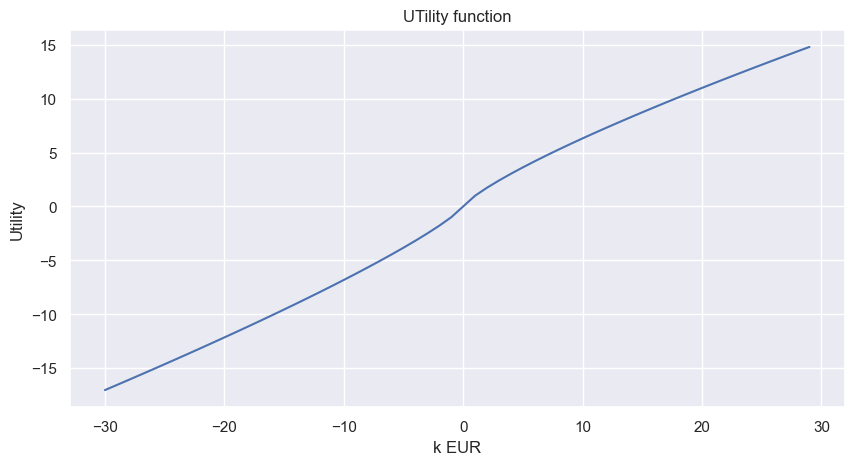

In [106]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(r[370:430],r_u[370:430])

plt.xlabel("k EUR")
plt.ylabel("Utility")
plt.title("UTility function")

plt.show()

In [107]:
uf_2(7.450580596923828e-09)

3.145952011997445e-07

In [108]:
uf_2(0.1)

0.15848931924611134

In [109]:

def uf_2(x):
    x = x / 1000

    if x <= 0:
        return -((-x) ** (1 / 1.2))
    else:
        return x ** (1 / 1.25)


def uf_2_inv(y):
    if y < 0:
        thousands = -((-y) ** 1.2)
    else:
        thousands = y ** 1.25

    return thousands * 1000

In [110]:
uf_2(500000)

144.2699905907214

In [111]:
uf_2_inv(144)

498830.63257983665

In [112]:
uf_2(uf_2_inv(-100100))

-100100.0

# Conclusion 
- I have made a simulation of the gas powerplant example for my thesis. 
- I have used parameters which come from reality (like the current price of gas, co2 and power) and I also made up some of the variables. 
- I have created two heuristic strategies and compared their results. 
- Now I need to create an optimal strategy finder and run the simulation with it. 